In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fix_yahoo_finance as yf

%matplotlib inline
sns.set()

In [2]:
symbol_list = ['LNG', 'SPY', 'SMLV']
start_date = '2017-04-01'
end_date = '2019-04-30'

In [3]:
# Get stocks price
full_df = yf.download(symbol_list, start=start_date, end=end_date)['Adj Close'].dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

# Shift monthly returns by 1 month forward so we can use it as a feature for future predictions 
returns_monthly_shifted = returns_monthly.shift(1).dropna()

print(returns_monthly_shifted.iloc[-1])

[*********************100%***********************]  3 of 3 downloaded
                 LNG      SMLV       SPY
Date                                    
2018-12-03  0.012172  0.020335  0.021165
2019-01-01 -0.047468 -0.094941 -0.099038
2019-02-01  0.112458  0.086267  0.079493
2019-03-01 -0.044348  0.037313  0.038344
2019-04-01  0.061875 -0.007946  0.023783
LNG    -0.044348
SMLV    0.037313
SPY     0.038344
Name: 2019-04-01 00:00:00, dtype: float64


In [4]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG      SMLV       SPY
LNG   0.000112  0.000012  0.000015
SMLV  0.000012  0.000047  0.000019
SPY   0.000015  0.000019  0.000016


In [5]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, returns in returns_monthly_shifted.iterrows():

    # Get the weight of the best sharpe ratio
    weight = np.asmatrix(covariances[date]).I * np.array(returns).reshape(-1,1)
    # Scale down and reshape the weight
    weight *= 1/weight.sum()
    targets.append(np.array(weight).reshape(1, -1)[0])
    features.append(returns)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print("Targets (weights):", targets[-5:]) 
print("Features (delay 1 returns):", features[-5:])

Targets (weights): [[ 1.09073583  1.2106531  -1.30138893]
 [-0.05878843  1.49386925 -0.43508082]
 [-0.05951228  0.56781012  0.49170216]
 [ 0.10834238  0.35349489  0.53816272]
 [-0.34527115 -0.25180398  1.59707513]]
Features (delay 1 returns): [[-0.11079465 -0.05180634 -0.0624394 ]
 [ 0.01217168  0.0203352   0.021165  ]
 [-0.04746835 -0.09494087 -0.09903784]
 [ 0.11245847  0.08626739  0.07949253]
 [-0.04434822  0.03731343  0.03834424]]


In [6]:
# Make train and test features
from sklearn.ensemble import RandomForestRegressor

train_size = int(0.7 * features.shape[0])
X_train = features[:train_size]
X_test = features[train_size:]
y_train = targets[:train_size]
y_test = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.8070465174889028
-3.108220058134601


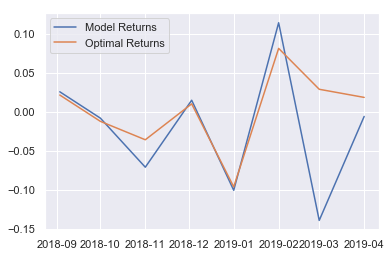

In [7]:
# Get predictions from model on train and test
train_predictions = rfr.predict(X_train)
test_predictions = rfr.predict(X_test)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size+1:] * test_predictions, axis=1)
optimal_returns = np.sum(returns_monthly.iloc[train_size+1:] * y_test, axis=1)
plt.plot(test_returns, label='Model Returns')
plt.plot(optimal_returns, label='Optimal Returns')
plt.MaxNLocator(5)
plt.legend()
plt.show()

In [8]:
# Calculate PnL when the initial investment is $1,000K
CF0 = 1000

test_PnL = CF0 * np.multiply.accumulate(1 + test_returns)
optimal_PnL = CF0 * np.multiply.accumulate(1 + optimal_returns)

print('Model Pnl:', test_PnL.iloc[-1])
print('Optimal Pnl:', optimal_PnL.iloc[-1])

Model Pnl: 823.7816694442464
Optimal Pnl: 1007.7902151243787


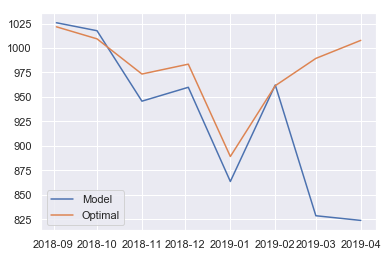

In [9]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(test_PnL, label='Model')
plt.plot(optimal_PnL, label='Optimal')
plt.MaxNLocator(5)
plt.legend()  # show the legend
plt.show()